# Import Libraries

In [1]:
import sys
sys.path.append("/home/felix/PycharmProjects/Quantum-Challenge/")
import pandas as pd
import xarray as xr
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import traceback
import math

import networkx as nx
import itertools

from qiskit.algorithms import AmplificationProblem
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover
from qiskit.circuit.library import GroverOperator
from qiskit.extensions import Initialize

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

from itertools import product 
from qiskit.quantum_info import Statevector
from importlib import reload

In [2]:
import utils.utils as ut

# Load flight Data 

In [3]:
flight_df = pd.read_csv("../data/flights.csv", sep=";")

# Load velocity and fuel consumption data

In [4]:
cruise_df = pd.read_pickle("../data/cruise_df.pkl")
climb_df = pd.read_pickle("../data/climb_df.pkl")
descent_df = pd.read_pickle("../data/descent_df.pkl")

# Load climate data

In [5]:
climate_df = pd.read_pickle("../data/climate_df.pkl")

# Classical non-optimization

In [118]:
def get_classical_traj():
    classical_trajectory_arr = []
    for index, t, z, x_s, y_s, x_e, y_e in flight_df.to_numpy():

        x_tr = np.linspace(x_s,x_e,100)
        y_tr = np.linspace(y_s,y_e,100)


        temp_trajec = []
        for i in range(99):        
            temp_trajec.append({"x": x_tr[i+1], "y":y_tr[i+1] })

        traj_voxel = []

        for c_1, i in enumerate(x_arr):
            for c_2, j in enumerate(y_arr):
                for c_3, l in enumerate(temp_trajec):
                    if i == x_arr[(np.abs(x_arr - temp_trajec[c_3]["x"]  )).argmin()] and j == y_arr[(np.abs(y_arr - temp_trajec[c_3]["y"]  )).argmin()]:
                        traj_voxel += [[x_arr[c_1],y_arr[c_2]]]

        traj_voxel_temp = np.unique(traj_voxel,axis=0)
        
        traj_voxel = [traj_voxel_temp[0]]
        for cnt, (x,y) in enumerate(traj_voxel_temp[1:]):
            if x != traj_voxel_temp[cnt][0] and y != traj_voxel_temp[cnt][1]:
                traj_voxel.append([x,traj_voxel_temp[cnt][1]])
                traj_voxel.append([x,y])
            else:
                traj_voxel.append([x,y])
        
        traj = [{"x": x_s, "y":y_s, "z":z , "t": np.datetime64('2018-06-23 '+ t) , "delta_t":np.timedelta64(0,'s')  }]
        for i in range(len(traj_voxel)-1):
            point_x = ut.x_to_km(traj_voxel[i+1][0] - traj_voxel[i][0])
            point_y = ut.y_to_km(traj_voxel[i+1][1] - traj_voxel[i][1])
            point_dist = np.sqrt(point_x**2 + point_y**2)

            point_t = int(3600 * point_dist/ (ut.find_fuel(cruise_df,z)[0] * 1.852))

            traj.append({"x": traj_voxel[i+1][0], "y":traj_voxel[i+1][1], "z":z , "t":traj[i]["t"] + np.timedelta64(point_t,'s'), "delta_t":np.timedelta64(point_t,'s')  })
        classical_trajectory_arr.append(traj)
    return classical_trajectory_arr
classical_trajectory_arr = get_classical_traj()

Example of shortest path trajectory:

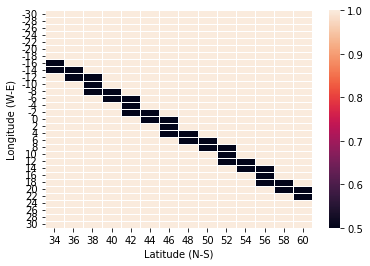

In [121]:
test_classical_traj = classical_trajectory_arr[5]
box_2d = np.zeros((x_arr.shape[0], y_arr.shape[0]))

for c_1, i in enumerate(x_arr):
    for c_2, j in enumerate(y_arr):
        box_2d[c_1][c_2] = 1
        for c_3, l in enumerate(test_classical_traj):
            if i == l["x"] and j == l["y"]:
                box_2d[c_1][c_2] = 0.5
                
                            
ax = sns.heatmap(box_2d,xticklabels= y_arr, yticklabels=x_arr, linewidths=0.5)
ax.set_ylabel("Longitude (W-E)")
ax.set_xlabel("Latitude (N-S)")
plt.show()

In [122]:
reload(ut)
classical_delta_T = np.sum([ut.C(tr) for tr in classical_trajectory_arr])
classical_delta_T

6.869211166897976e-06

In [123]:
np.sum([ut.consumed_fuel(tr)[0] for tr in classical_trajectory_arr])

2126269.6783333337

In [168]:
np.sum([ut.time_traveled(tr)for tr in classical_trajectory_arr])

numpy.timedelta64(2782152,'s')

# Classical Optimization

In [74]:
G = ut.get_3d_graph()
ut.add_weights_graph(G)
# nx.write_gpickle(G, "../data/w_graph.pkl")
# G = nx.read_gpickle("../data/w_graph.pkl")

0

In [135]:
classical_climate_trajectory_arr = []
for s_inx, (_, t, z, x_s, y_s, x_e, y_e) in enumerate(flight_df.to_numpy()):
    tuple_path = ut.gen_shortest_path(G, x_s, y_s, z, x_e, y_e, z)
    test_trajec = ut.tuple_path_to_trajec(tuple_path, start_index = s_inx) 
    classical_climate_trajectory_arr.append(test_trajec)

In [156]:
# reload(ut)
classical_climate_trajectory_arr = []
for s_inx, (_, t, z, x_s, y_s, x_e, y_e) in enumerate(flight_df.to_numpy()):
    
    temp_save = []
    for z_e in z_arr:
        tuple_path = ut.gen_shortest_path(G, x_s, y_s, z, x_e, y_e, z_e)
        if tuple_path == []:
            continue
        test_trajec = ut.tuple_path_to_trajec(tuple_path, start_index=s_inx)
        temp_save.append(test_trajec)
    temp_cost = [ut.C(tr) for tr in temp_save]
    min_inx = np.argmin(temp_cost)
    
    classical_climate_trajectory_arr.append(temp_save[min_inx])
    

In [169]:
np.save("../data/c_climate_trajectory_arr.npy",np.array(classical_climate_trajectory_arr,dtype=object))

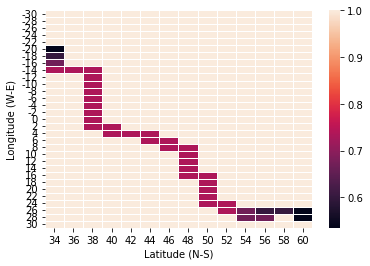

In [144]:
test_classical_traj = classical_climate_trajectory_arr[11]
box_2d = np.zeros((x_arr.shape[0], y_arr.shape[0]))

for c_1, i in enumerate(x_arr):
    for c_2, j in enumerate(y_arr):
        box_2d[c_1][c_2] = 1
        for c_3, l in enumerate(test_classical_traj):
            if i == l["x"] and j == l["y"]:
                box_2d[c_1][c_2] = ut.graph_plot_scale(l["z"])
                
                            
ax = sns.heatmap(box_2d,xticklabels= y_arr, yticklabels=x_arr, linewidths=0.5)
ax.set_ylabel("Longitude (W-E)")
ax.set_xlabel("Latitude (N-S)")
plt.show()

In [157]:
classical_climate_delta_T = np.sum([ut.C(tr) for tr in classical_climate_trajectory_arr])
classical_climate_delta_T

5.024468851809599e-06

In [158]:
np.sum([ut.consumed_fuel(tr)[0] for tr in classical_climate_trajectory_arr])

1854540.6850377168

In [167]:
np.sum([ut.time_traveled(tr)for tr in classical_climate_trajectory_arr])

numpy.timedelta64(2680147,'s')